In [14]:
from dotenv import load_dotenv
import os

import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [15]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [16]:
load_dotenv()

fred_api_key = os.getenv("fred_api_key")
fred = Fred(api_key=fred_api_key)

In [17]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [18]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [19]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS'], train0_df['ffef_tr'], 0, None)
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], 0, model_stats_df)
                              
model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], 0, model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], 0, model_stats_df )                         

model_stats_df

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (197, 25)
test_df:  (49, 25)


,name,mse,rmse,mape,mae,aic
0,ffef_tr_train,25.4002,5.0399,2.1100,4.4310,0
1,ffef_tr_test,57.2779,7.5682,41.6492,6.8936,0
2,ffef_tr2_train,1.1202,1.0584,0.2525,0.6816,0
3,ffef_tr2_test,0.3307,0.5750,3.4681,0.4071,0


# Load Data

# Stats Model - Taylor Index

In [20]:
taylor_df = load_taylor()
taylor_df = taylor_df.query('index < "2007-01-01"')
train_df, test_df = time_split(taylor_df)

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (144, 25)
test_df:  (36, 25)


In [21]:
X_train = train_df[['FEDFUNDS-1']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['FEDFUNDS-1']]
y_test = test_df['FEDFUNDS']

In [22]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
#cat_columns_lst = ['recession_flag','chair_name']
#cat_columns_lst = ['recession_flag']
num_columns_lst = ['FEDFUNDS-1']


#ohe_categories = list()
#for c in cat_columns_lst:
#    ohe_categories.append(list(X_train[c].unique()))
    
#ohe = OneHotEncoder(categories=ohe_categories, drop='first',
#                   sparse_output=False, handle_unknown='ignore')

#transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')



numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
#categorical_transformer = Pipeline( steps=[('transformer',transformer)])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
#        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [23]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)


X_train_const = sm.add_constant(X_train_trf)

In [24]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1140.
Date:                Mon, 01 Jan 2024   Prob (F-statistic):           1.00e-69
Time:                        19:58:31   Log-Likelihood:                -213.97
No. Observations:                 144   AIC:                             431.9
Df Residuals:                     142   BIC:                             437.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4533      0.211      2.148      0.033       0.036       0.870
num__FEDFUNDS-1     0.9373      0.028     33.766      0.000       0.882       0.992
==============================================================================
Omnibus:                       51.327   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              408.524
Skew:                           0.967   Prob(JB):                     1.95e-89
Kurtosis:                      11.021   Cond. No.                         18.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [26]:
#model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [27]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (36, 2)


In [28]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(36, 6)

In [29]:
#model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

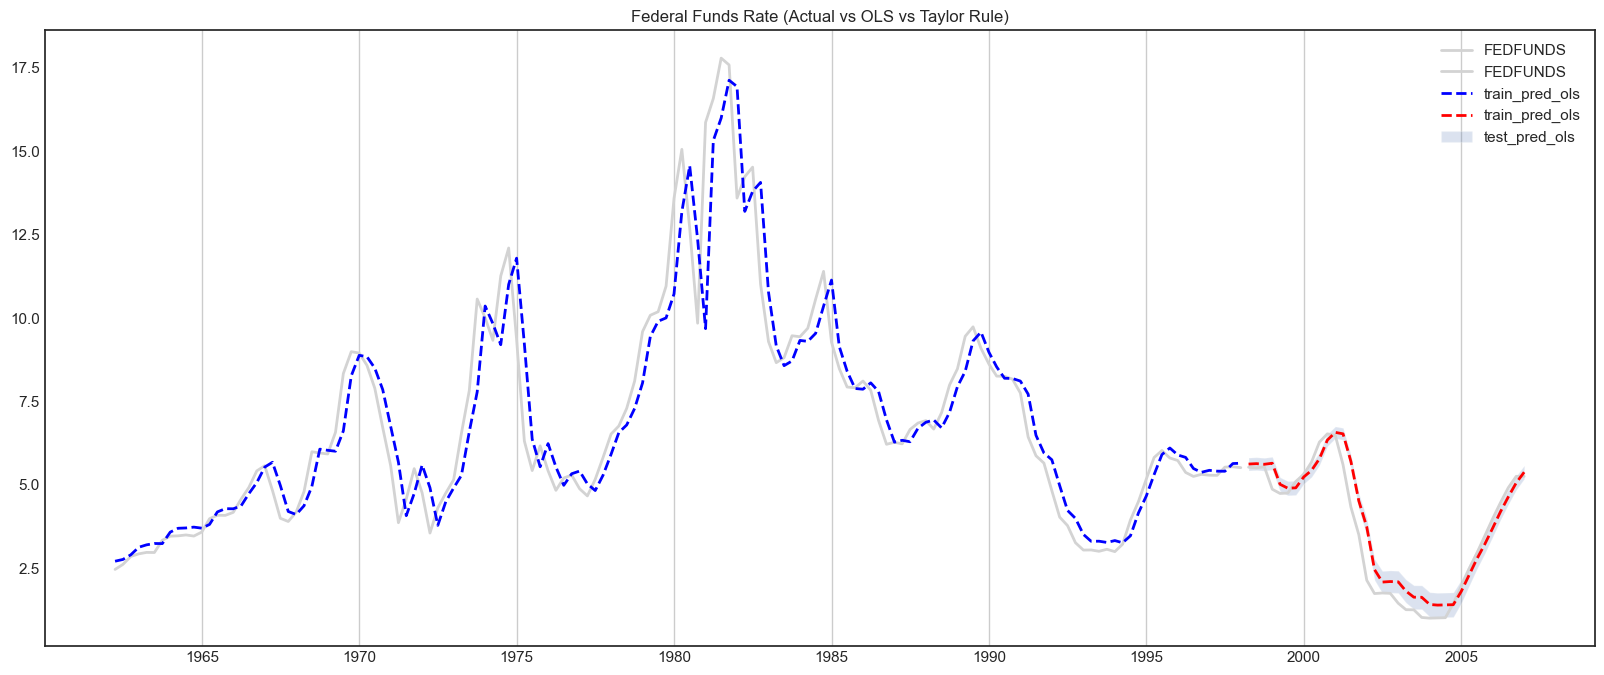

In [30]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# LGBM

In [31]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_lgbm = ltb_model.predict(X_train_trf, pred_contrib=False, raw_score=False)

<Axes: >

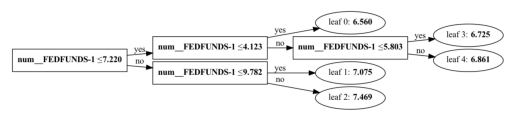

In [32]:
ltb.plot_tree(ltb_model)

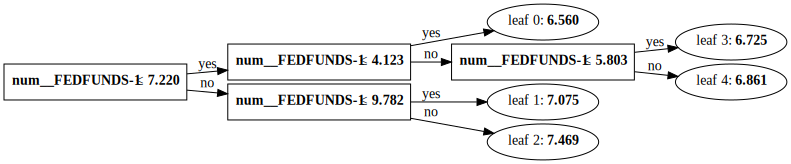

In [33]:
ltb.create_tree_digraph(ltb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

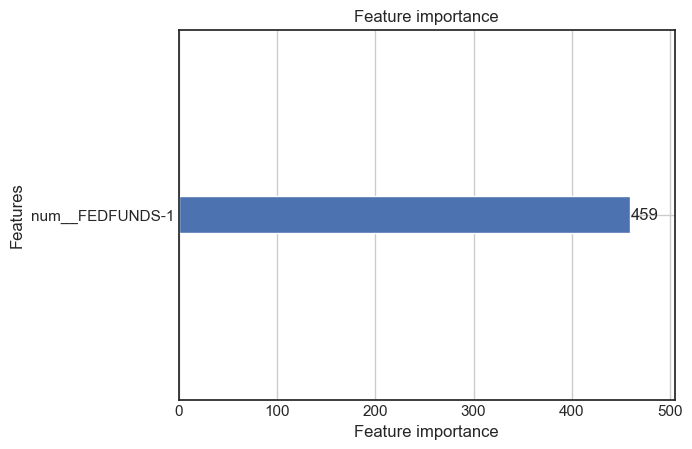

In [34]:
ltb.plot_importance(ltb_model)

In [35]:
#model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1]  , model_stats_df )

## Test

In [36]:
test_pred_lgbm = ltb_model.predict(X_test_trf, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(36,)

In [37]:
#model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

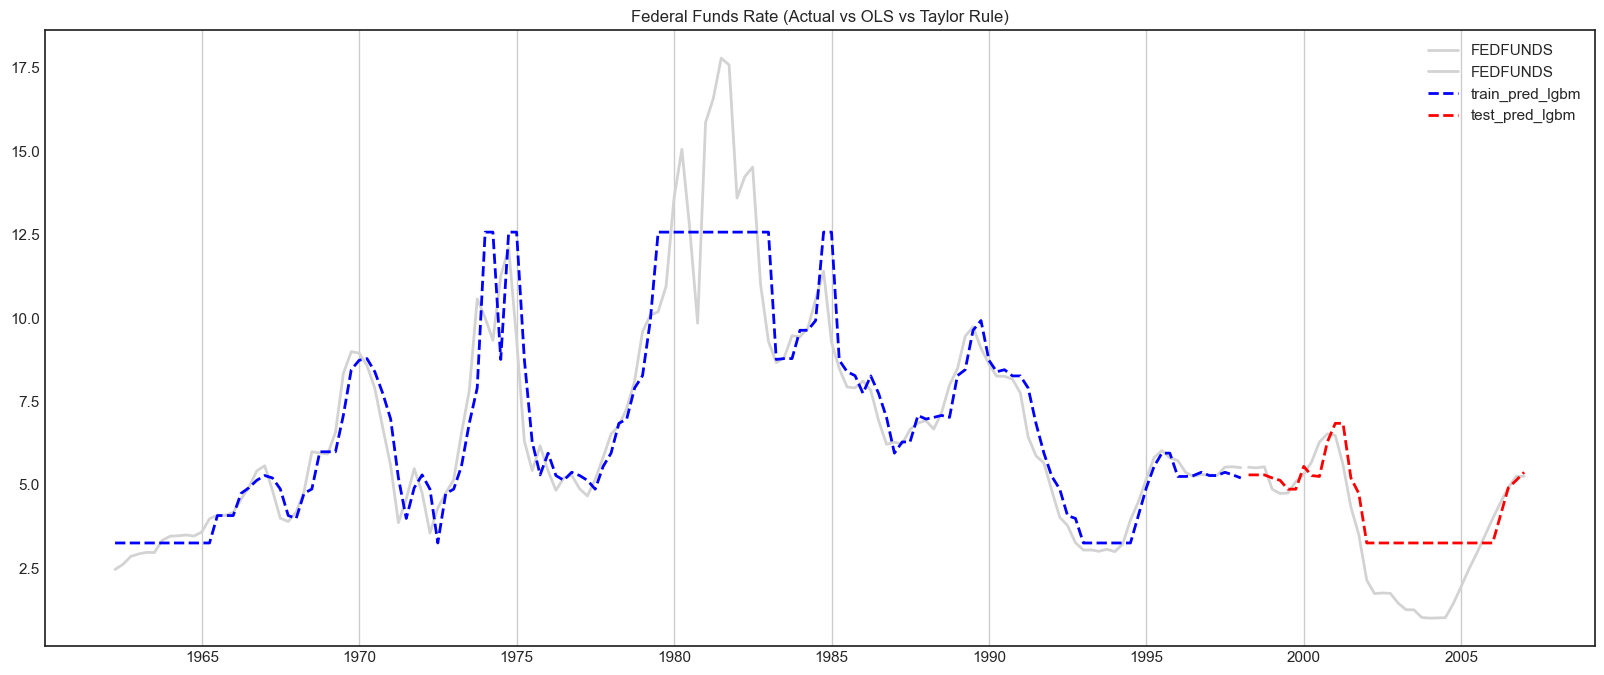

In [38]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# XGB

In [39]:
xgb_model = xgb.XGBRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_xgb = xgb_model.predict(X_train_trf)
xgb_model.score(X_train_trf, y_train)

0.9998600291616896

In [40]:
#model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], X_train.shape[1], model_stats_df )

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

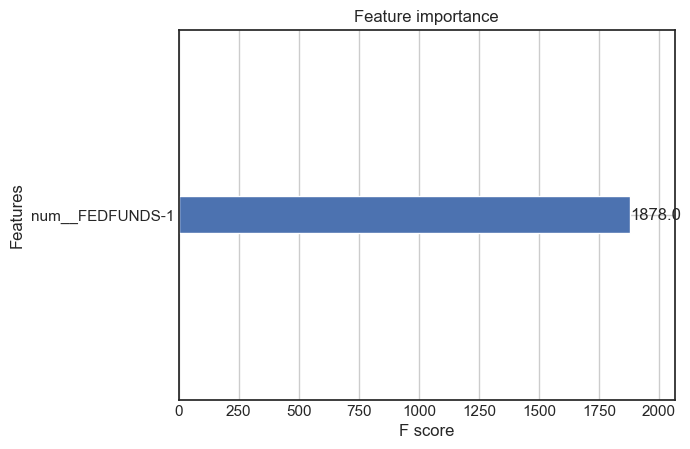

In [41]:
xgb.plot_importance(xgb_model)

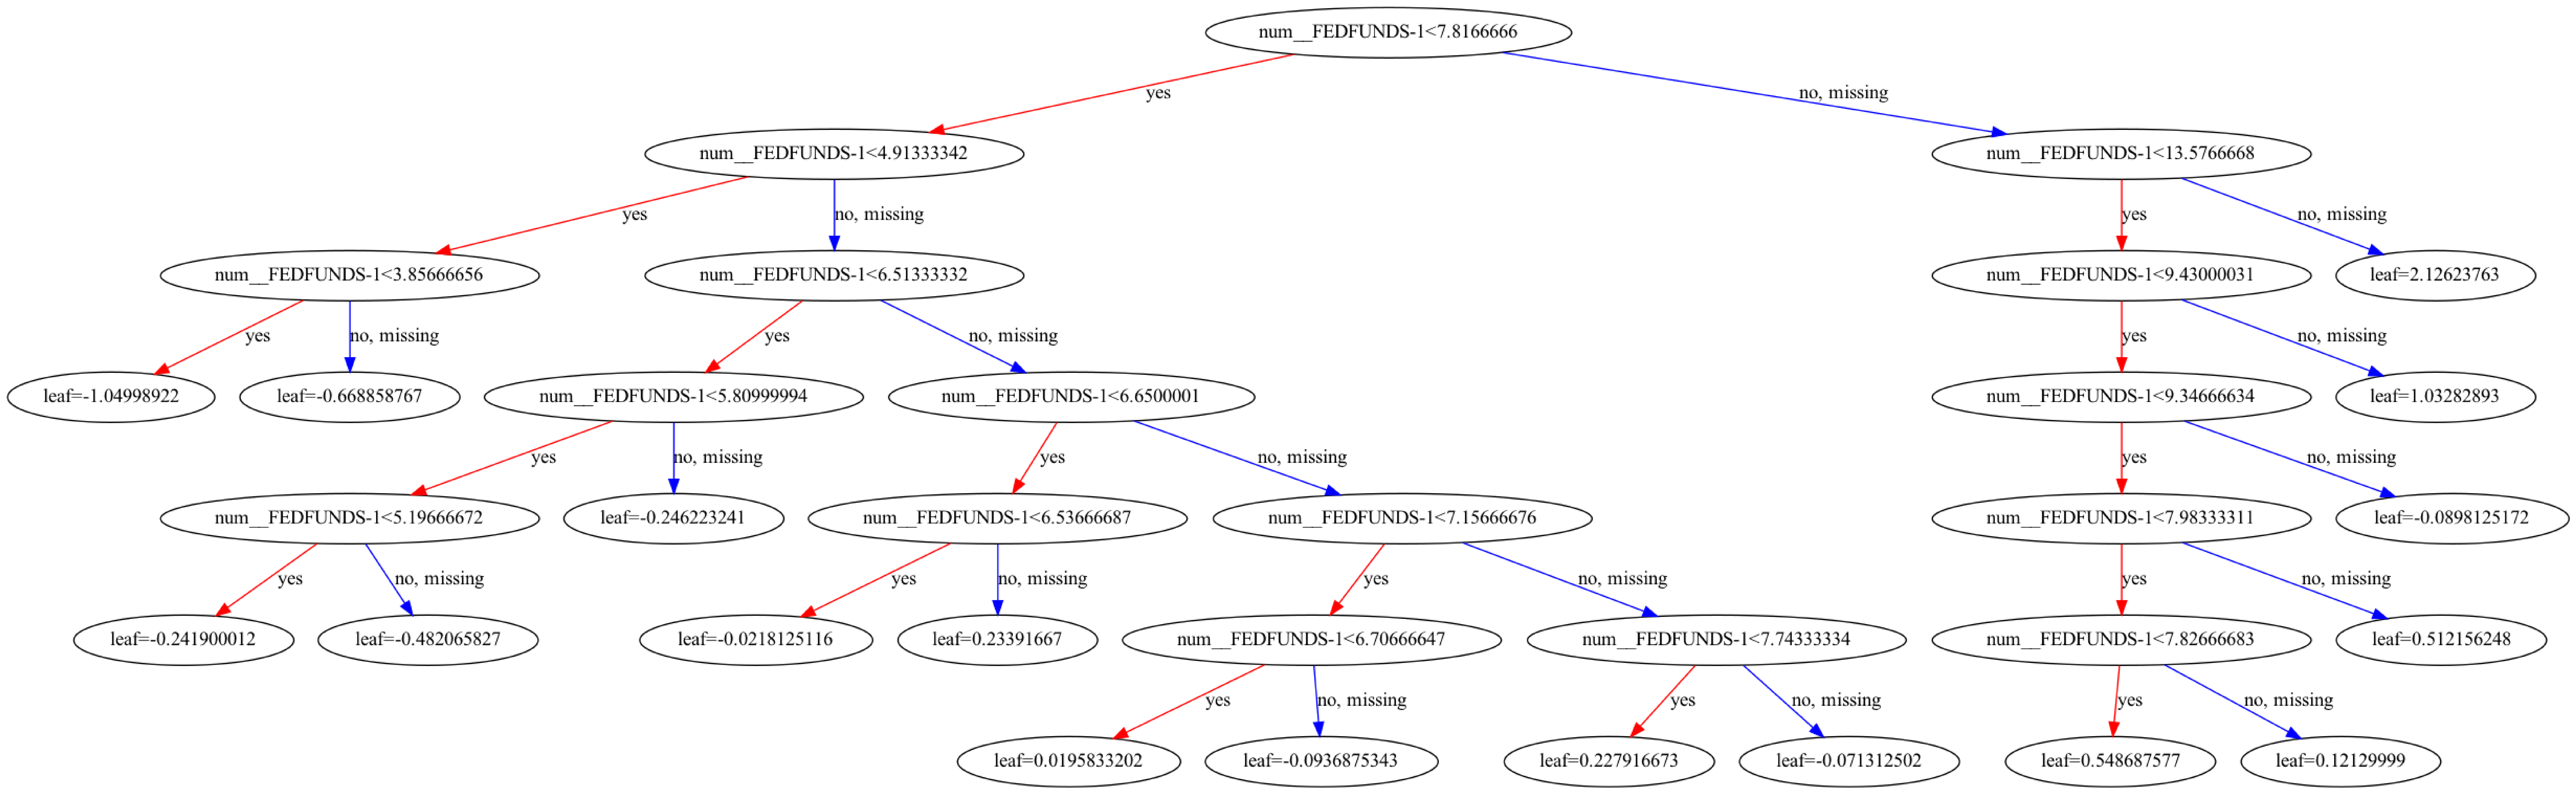

In [42]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(xgb_model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

fig.show()

## Test

In [43]:
test_pred_xgb = xgb_model.predict(X_test_trf)
test_pred_xgb.shape

(36,)

In [44]:
#model_stats_df = model_results('xgb_test', y_test, test_pred_xgb, X_train.shape[0], X_test.shape[1] , model_stats_df )

# AdaBoostRegressor

In [45]:
ada_model = AdaBoostRegressor().fit(X_train_trf, y_train)
train_pred_ada = ada_model.predict(X_train_trf)

#model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

In [46]:
test_pred_ada = ada_model.predict(X_test_trf)
#model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_train_trf.shape[0], 2 , model_stats_df )

# tsa.SARIMAX

In [47]:
taylor2006_df = load_taylor()
#taylor2006_df = taylor2006_df.query('index < "2007-01-01"')
taylor2006_df

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)


,FEDFUNDS,UNRATE,TB3MS,GDPC1,GDPPOT,GDPDEF_PC1,CPIAUCSL_PC1,Growth_g,Real_Interest_Rate,Output_Gap,...,gap_inf,gap_gdp,gap_ue,ffef_tr,ffef_tr2,ffef_tr_diff,ffef_tr2_diff,recession_flag,chair_name,chair_index
DATE,,,,,,,,,,,,,,,,,,,,,
1962-03-31,2.456667,5.633333,2.723333,3758.147,3510.589803,1.3,0.893657,4.767864,5.431519,-1.116593,...,-1.106343,7.051727,0.633333,6.272692,2.915301,0.819163,0.618994,False,Martin,8
1962-06-30,2.606667,5.533333,2.716667,3792.149,3547.393872,1.3,1.307420,4.312286,4.905557,-0.527162,...,-0.692580,6.899576,0.533333,6.403498,2.976170,0.130806,0.060869,False,Martin,8
1962-09-30,2.846667,5.566667,2.840000,3838.776,3586.443274,1.2,1.201973,4.216468,4.792678,-0.191603,...,-0.798027,7.035737,0.566667,6.318855,3.063512,-0.084643,0.087343,False,Martin,8
1962-12-31,2.923333,5.533333,2.813333,3851.421,3626.627231,1.1,1.300453,3.824744,4.330072,-0.054464,...,-0.699547,6.198425,0.533333,5.849439,3.219780,-0.469416,0.156267,False,Martin,8
1963-03-31,2.966667,5.766667,2.906667,3893.482,3666.778391,1.0,1.229113,3.806057,4.314261,0.154364,...,-0.770887,6.182637,0.766667,5.705875,3.270023,-0.143564,0.050244,False,Martin,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.770000,3.600000,1.076667,21708.160,20153.810000,7.7,8.554363,1.728947,0.666278,4.479321,...,6.554363,7.712437,-1.400000,16.833400,1.955673,0.732158,0.106262,False,Powell,15
2022-09-30,2.190000,3.566667,2.663333,21851.134,20245.660000,7.3,8.285130,1.850930,0.785472,4.164357,...,6.285130,7.929966,-1.433333,16.407548,2.464975,-0.425852,0.509302,False,Powell,15
2022-12-31,3.653333,3.600000,4.040000,21989.981,20334.210000,6.4,7.114260,1.825866,0.717093,4.018788,...,5.114260,8.142785,-1.400000,15.028522,3.398772,-1.379026,0.933797,False,Powell,15


In [48]:
train2006_df, test2006_df = time_split(taylor2006_df)

train_df:  (197, 25)
test_df:  (49, 25)


In [49]:
#X_train = train2006_df[['FEDFUNDS-1']]
X_train = train2006_df[['FEDFUNDS-1']]
X_train_trf = t_fit.transform(X_train)


y_train = train2006_df['FEDFUNDS']

In [50]:
model = sm.tsa.SARIMAX(y_train, exog=X_train_trf)
#model = sm.tsa.SARIMAX(y_train, exog=X_train)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  197
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -266.712
Date:                Mon, 01 Jan 2024   AIC                            539.424
Time:                        19:58:40   BIC                            549.274
Sample:                    03-31-1962   HQIC                           543.411
                         - 03-31-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9830      0.008    115.769      0.000       0.966       1.000
ar.L1          0.2439      0.054      4.514      0.000       0.138       0.350
sigma2         0.8777      0.042     20.993      0.000       0.796       0.960
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):              2020.13
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [55]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS,mean,mean_se,mean_ci_lower,mean_ci_upper
1962-03-31,2.359255,0.966032,0.465867,4.252644
1962-06-30,2.414960,0.966032,0.521571,4.308349
1962-09-30,2.562414,0.966032,0.669025,4.455802
1962-12-31,2.798339,0.966032,0.904950,4.691728
1963-03-31,2.873704,0.966032,0.980315,4.767093
...,...,...,...,...
2010-03-31,0.117963,0.966032,-1.775426,2.011352
2010-06-30,0.131070,0.966032,-1.762319,2.024459
2010-09-30,0.190051,0.966032,-1.703338,2.083440
2010-12-31,0.183498,0.966032,-1.709891,2.076886


## Test

In [59]:
X_test = test2006_df[['FEDFUNDS-1']]
X_test_trf = t_fit.transform(X_test)

y_test = test2006_df['FEDFUNDS']

In [60]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [61]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(49, 4)

In [62]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

,lower FEDFUNDS,upper FEDFUNDS
2011-06-30,-0.484433,0.779356
2011-09-30,-0.560272,0.740576
2011-12-31,-0.569981,0.733039
2012-03-31,-0.579582,0.723568
2012-06-30,-0.550023,0.753135


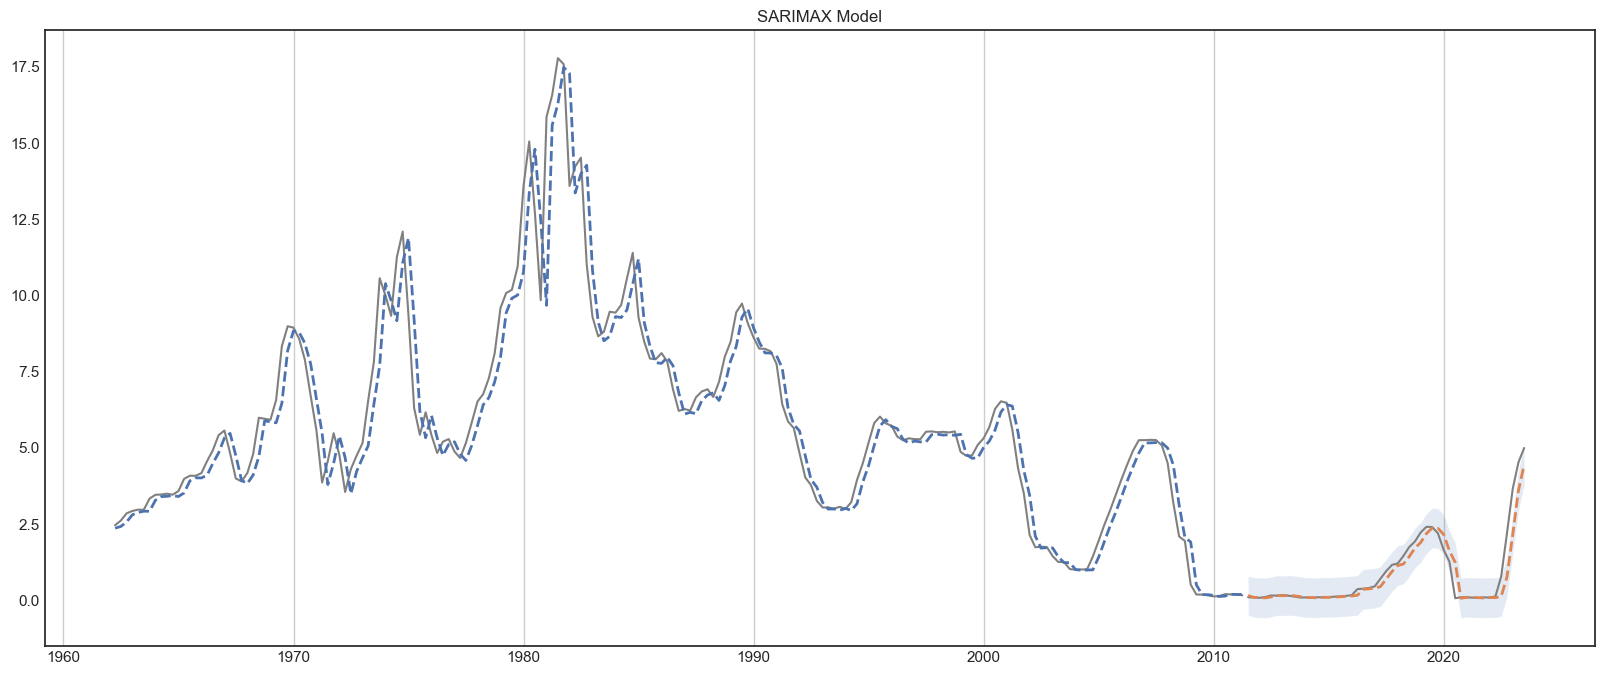

In [63]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train2006_df.index, train2006_df['FEDFUNDS'], 'gray')
ax.plot(test2006_df.index, test2006_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [64]:
print('SARIMAX RMSE(Train):' , statsmodels.tools.eval_measures.rmse(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX RMSE(Test):' , statsmodels.tools.eval_measures.rmse(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX RMSE(Train): 0.9663455209498859
SARIMAX RMSE(Test): 0.41191097432251017


In [65]:
print('SARIMAX R-Squard(Train):' , r2_score(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX R-Squard(Test):' , r2_score(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX R-Squard(Train): 0.9202190218430484
SARIMAX R-Squard(Test): 0.8776308761231848


In [66]:
X_train.shape[1]

1

In [67]:
#model_stats_df = model_results('SARIMAX_train',train2006_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )
#model_stats_df = model_results('SARIMAX_test', test2006_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )
#model_stats_df